# TOV Emulator to train a NN on real data to predict mass and radius of a Neutron Strar from prerecorded DATA

### <div style= 'color: slateblue'>Load the example dataset.

In [ ]:
import pandas as pd
import numpy as np

file_path = "All_MR_Relations/All_MR_Relations/MREoSm55L50J32T0_n150_Yp+RGgen_v0.00d0.90Bn000.dat"
col_names = ["logrho_c", "mass", "radius", "Gamma", "radius_of_quark_core", "baryonic_mass"]

df = pd.read_csv(file_path, delim_whitespace=True, header=None, names=col_names, comment="#")

np.save("EOS_data_real.npy", df.to_numpy())

In [ ]:
data = np.load("EOS_data_real.npy")
data[ : , :].shape

### <div style= 'color: slateblue'>Create the full dataset from the files

In [ ]:
import os
import re
import numpy as np
from tqdm import tqdm

# Path where all .dat files are located
DATA_DIR = "All_MR_Relations/All_MR_Relations"

# Regex to extract parameters from filenames
# Example: MREoSm55L50J32T0_n150_Yp+RGgen_v0.00d0.90Bn000.dat
import re

pattern = re.compile(
    r"MREoSm(?P<m>\d+)"
    r"L(?P<L>\d+)"
    r"J(?P<J>\d+)"
    r"T(?P<T>\d+)_"
    r"n(?P<n>\d+)_"
    r"Yp?\+.*?RGgen_"
    r"v(?P<n_v>[-\d\.]+)"
    r"d(?P<d>[-\d\.]+)"
    r"B(?P<Btype>[np])(?P<B>\d+)\.dat"
)

# Collect data points
dataset = []

# Iterate through all .dat files
for filename in tqdm(os.listdir(DATA_DIR)):
    if not filename.endswith(".dat"):
        continue

    match = pattern.match(filename)
    if not match:
        print(f"Skipping {filename} (pattern mismatch)")
        continue

    # Parse EOS parameters
    m = float(match.group("m")) / 100.0 # mass (FIXED)
    L = float(match.group("L")) # slope parameter (FIXED)
    n_v = float(match.group("n_v")) # vector coupling
    d = float(match.group("d")) # dipole coupling 
    B = float(match.group("B")) / 1000.0  # back constant optional scaling
    Btype = match.group("Btype")  # 'n' or 'p'

    # Load columns from file
    try:
        data = np.loadtxt(os.path.join(DATA_DIR, filename))
    except Exception as e:
        print(f"Error reading {filename}: {e}")
        continue

    # Expecting 6 columns: P_c, M, R, Lambda, R_quark, M_b
    if data.ndim == 1 or data.shape[1] < 3:
        continue

    mass = data[:, 1]      # Mass column
    radius = data[:, 2]    # Radius column

    # Build input-output pairs
    inputs = np.column_stack([np.full_like(mass, m),
                              np.full_like(mass, L),
                              np.full_like(mass, n_v),
                              np.full_like(mass, d),
                              np.full_like(mass, B),
                              mass])
    outputs = radius

    # Stack horizontally: each row is [m, L, n_v, d, B, Mass, Radius]
    dataset.append(np.column_stack([inputs, outputs]))

# Combine all files
if len(dataset) == 0:
    raise RuntimeError("No valid data collected — check path or regex pattern.")

dataset = np.vstack(dataset)

# Shuffle dataset
np.random.shuffle(dataset)

# Save as NumPy file
np.save("EOS_dataset_2.npy", dataset)

print("Dataset shape:", dataset.shape)
print("Saved to EOS_dataset.npy")

### <div style= 'color: slateblue'>DATA creation pipeline

* Step 1: Set the number of files used.
* Step 2: Select the specified number of files randomly.
* Step 3: For each file extract the EOS parameters from the name and the 400 MR values contained within it and stack it into a dataset. (Look at NN EPLANATION in Chat for explanation)
* Step 4: Save the following: 
    * The dataset
    * The list of files used (for validation) 

In [1]:
import os
import re
import numpy as np
from tqdm import tqdm
import glob

# ==============================================================================
# 1. NEW PARAMETER: Control the number of files used
# ==============================================================================
NUM_FILES_TO_USE = 100

# Path where all .dat files are located (Using glob for better file listing)
DATA_DIR_PATH = "/home/kay/ML-for-Neutron-Stars/3_PP_emulator_real_data/All_MR_Relations/All_MR_Relations/" # Adjusted to use the full path from previous question

# Regex to extract parameters from filenames
pattern = re.compile(
    r"MREoSm(?P<m>\d+)"
    r"L(?P<L>\d+)"
    r"J(?P<J>\d+)"
    r"T(?P<T>\d+)_"
    r"n(?P<n>\d+)_"
    r"Yp?\+.*?RGgen_"
    r"v(?P<n_v>[-\d\.]+)"
    r"d(?P<d>[-\d\.]+)"
    r"B(?P<Btype>[np])(?P<B>\d+)\.dat"
)

# ==============================================================================
# 2. SELECT FILES RANDOMLY BEFORE PROCESSING
# ==============================================================================
all_files = glob.glob(os.path.join(DATA_DIR_PATH, "MR*.dat"))

if len(all_files) == 0:
    raise RuntimeError(f"No .dat files found in {DATA_DIR_PATH}. Check your path.")

# Select a random subset of files based on NUM_FILES_TO_USE
if len(all_files) < NUM_FILES_TO_USE:
    print(f"Warning: Only found {len(all_files)} files. Using all of them.")
    selected_files = all_files
else:
    selected_files = np.random.choice(all_files, size=NUM_FILES_TO_USE, replace=False)

# ==============================================================================
# 3. FILE SELECTION ITERATION LOOP
# ==============================================================================
dataset_rows = [] # Collect data points
# List to log the full paths of the files used for the training set
files_used_for_training = [] 

for file_path in tqdm(selected_files, desc="Processing files"):
    filename = os.path.basename(file_path)

    match = pattern.match(filename)
    if not match:
        # This means the selected file did not match the expected pattern
        print(f"Skipping {filename} (pattern mismatch)")
        continue
    
    # Log the file path for validation later
    files_used_for_training.append(file_path)

    # Parse EOS parameters
    m = float(match.group("m")) / 100.0
    L = float(match.group("L"))
    n_v = float(match.group("n_v"))
    d = float(match.group("d"))
    B = float(match.group("B")) / 1000.0

    # Load columns from file
    try:
        data = np.loadtxt(file_path)
    except Exception as e:
        print(f"Error reading {filename}: {e}")
        continue

    # Expecting 6 columns: P_c, M, R, Lambda, R_quark, M_b
    if data.ndim == 1 or data.shape[1] < 3:
        print(f"Skipping malformed file: {filename}")
        continue

    # Physical M–R curve
    mass = data[:, 1]       # Mass column
    radius = data[:, 2]     # Radius column

    # Skip broken curves
    if np.any(radius <= 0) or np.any(mass <= 0):
        continue

    # Build input-output pairs
    eos_params = np.column_stack([np.full_like(mass, m),
                              np.full_like(mass, L),
                              np.full_like(mass, n_v),
                              np.full_like(mass, d),
                              np.full_like(mass, B),
                              ])
    rows = np.column_stack([eos_params, mass, radius])
    # Stack horizontally: each row is [m, L, n_v, d, B, Mass, Radius] one training sample
    dataset_rows.append(rows)

# Combine all files
if len(dataset_rows) == 0:
    raise RuntimeError("No valid data collected.")

dataset = np.vstack(dataset_rows)
# Shuffle dataset
np.random.shuffle(dataset)

np.save(f"Datasets/EOS_training_dataset_{NUM_FILES_TO_USE}_files", dataset)
# Save the list of files used! This is what you need for validation.
np.save(f"Datasets/{NUM_FILES_TO_USE}files_used_for_training.npy", np.array(files_used_for_training))

print("\nDataset shape:", dataset.shape)
print("Example row: [m, L, n_v, d, B, M, R]")
print(dataset[0])

Processing files: 100%|██████████| 100/100 [00:00<00:00, 346.58it/s]




Dataset shape: (40000, 7)
Example row: [m, L, n_v, d, B, M, R]
[  0.6        100.           0.65         1.55         0.15
   0.35018403  15.39709915]


### <div style= 'color: yellow'> Ranges of values of the parameters within the subset

In [2]:
print("Nuclear Mass min/max:", np.round(dataset[:, 0].min(), 3), np.round(dataset[:, 0].max(), 3))
print("Slape parmeter min/max:", np.round(dataset[:, 1].min(), 3), np.round(dataset[:, 1].max(), 3))
print("Vector coupling min/max:", np.round(dataset[:, 2].min(), 3), np.round(dataset[:, 2].max(), 3))
print("Dipole coupling min/max:", np.round(dataset[:, 3].min(), 3), np.round(dataset[:, 3].max(), 3))
print("Back constant min/max:", np.round(dataset[:, 4].min(), 3), np.round(dataset[:, 4].max(), 3))

print("Mass min/max:", np.round(dataset[:, 5].min(), 3), np.round(dataset[:, 5].max(), 3))
print("Radius min/max:", np.round(dataset[:, 6].min(), 3), np.round(dataset[:, 6].max(), 3))

Nuclear Mass min/max: 0.55 0.75
Slape parmeter min/max: 40.0 145.0
Vector coupling min/max: 0.0 1.4
Dipole coupling min/max: 0.9 2.0
Back constant min/max: 0.0 0.2
Mass min/max: 0.088 3.304
Radius min/max: 6.833 98.312


### <div style= 'color: orange'> Produce a mass-radius curve for a single EOS

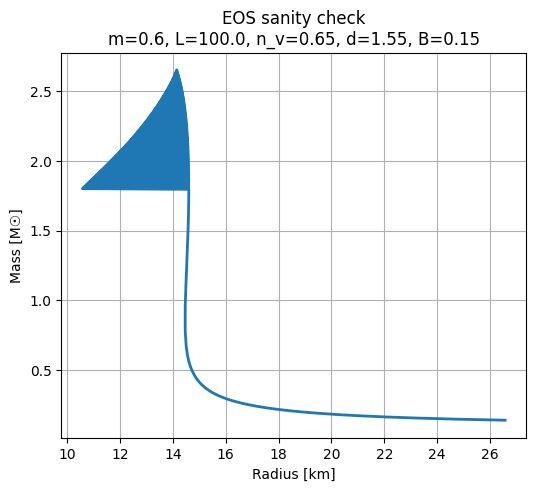

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------------------------------
# Extract ONE eos curve
# -------------------------------------------------------
# Pick a specific index (0 = first file in dataset before shuffling)
# But because the dataset is shuffled, we instead extract a *single EOS*
# by matching identical (m, L, n_v, d, B).
m0, L0, nv0, d0, B0 = dataset[0, :5]

mask = (
    (dataset[:,0] == m0) &
    (dataset[:,1] == L0) &
    (dataset[:,2] == nv0) &
    (dataset[:,3] == d0) &
    (dataset[:,4] == B0)
)

subset = dataset[mask]

mass = subset[:, 5]
radius = subset[:, 6]

# Sort by mass so plot looks clean
order = np.argsort(mass)
mass = mass[order]
radius = radius[order]

# -------------------------------------------------------
# Plot
# -------------------------------------------------------
plt.figure(figsize=(6,5))
plt.plot(radius, mass, linewidth=2)
plt.xlabel("Radius [km]")
plt.ylabel("Mass [M☉]")
plt.title(f"EOS sanity check\nm={m0}, L={L0}, n_v={nv0}, d={d0}, B={B0}")
plt.grid(True)
plt.show()


### <div style= 'color: yellow'> PyTorch ML pipeline — Prepare the data

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Convert to pytorch tensors
X = torch.tensor(dataset[:, :6], dtype=torch.float32)  # m, L, n_v, d, B, Mass
y = torch.tensor(dataset[:, 6:], dtype=torch.float32)  # Radius

# Scale features by known physical ranges
X_scaled = X.clone()
X_scaled[:,0] /= 1.0      # m*/m0 approx 0.55–0.75 leave as is
X_scaled[:,1] /= 100.0    # L in MeV → ~0.4–1.45
X_scaled[:,2] /= 1.0      # g_v/g_s already small
X_scaled[:,3] /= 1.0      # dipole coupling
X_scaled[:,4] /= 0.2      # B → 0–1 range
X_scaled[:,5] /= 1.0      # Mass in M☉ leave as is 

# Log-transform targets
y_log = torch.log(y + 1e-6)

# Shuffling the dataset
indices = torch.randperm(len(X_scaled))
train_size = int(0.8 * len(X_scaled))
train_idx = indices[:train_size]
val_idx = indices[train_size:]

# Split into training and validation sets
X_train, X_val = X_scaled[train_idx], X_scaled[val_idx]
y_train, y_val = y_log[train_idx], y_log[val_idx]

# Compute mean and std only on the training dataset
X_mean, X_std = X_train.mean(dim=0, keepdim=True), X_train.std(dim=0, keepdim=True)
y_mean, y_std = y_train.mean(dim=0, keepdim=True), y_train.std(dim=0, keepdim=True)

# avoid division by zero
X_std[X_std == 0] = 1.0
y_std[y_std == 0] = 1.0

# Normalize inputs and outputs of the training and validation datasets
X_train_norm = (X_train - X_mean) / X_std
y_train_norm = (y_train - y_mean) / y_std
X_val_norm   = (X_val - X_mean) / X_std
y_val_norm   = (y_val - y_mean) / y_std

# Reshape the tensors for dataloader
X_train_norm, y_train_norm = X_train_norm.view(-1, 6), y_train_norm.view(-1, 1)
X_val_norm, y_val_norm = X_val_norm.view(-1, 6), y_val_norm.view(-1, 1)

print("X_train mean:", X_mean)
print("X_train std:", X_std)
print("y_train mean:", y_mean)
print("y_train std:", y_std)

Using device: cuda
X_train mean: tensor([[0.6304, 0.7334, 0.7982, 1.4289, 0.5610, 1.3444]])
X_train std: tensor([[0.0667, 0.2721, 0.3796, 0.2741, 0.3165, 0.8906]])
y_train mean: tensor([[2.6267]])
y_train std: tensor([[0.2155]])


### <div style= 'color: yellow'> Ranges of values of the parameters within the tensors after scaling and normalizing

In [5]:
print("Nuclear Mass min/max:", np.round(X_train_norm[:, 0].min(), 3), np.round(X_train_norm[:, 0].max(), 3))
print("Slape parmeter min/max:", np.round(X_train_norm[:, 1].min(), 3), np.round(X_train_norm[:, 1].max(), 3))
print("Vector coupling min/max:", np.round(X_train_norm[:, 2].min(), 3), np.round(X_train_norm[:, 2].max(), 3))
print("Dipole coupling min/max:", np.round(X_train_norm[:, 3].min(), 3), np.round(X_train_norm[:, 3].max(), 3))
print("Back constant min/max:", np.round(X_train_norm[:, 4].min(), 3), np.round(X_train_norm[:, 4].max(), 3))
print("Mass min/max:", np.round(X_train_norm[:, 5].min(), 3), np.round(X_train_norm[:, 5].max(), 3))

print("Radius min/max:", np.round(y_train_norm[:, 0].min(), 3), np.round(y_train_norm[:, 0].max(), 3))

Nuclear Mass min/max: tensor(-1.2060) tensor(1.7930)
Slape parmeter min/max: tensor(-1.2250) tensor(2.6340)
Vector coupling min/max: tensor(-2.1030) tensor(1.5850)
Dipole coupling min/max: tensor(-1.9290) tensor(2.0830)
Back constant min/max: tensor(-1.7730) tensor(1.3870)
Mass min/max: tensor(-1.4110) tensor(2.2000)
Radius min/max: tensor(-3.2710) tensor(9.1020)


In [6]:
print(X_train_norm.mean(dim=0), X_train_norm.std(dim=0))
print(y_train_norm.mean(), y_train_norm.std())

tensor([-3.4213e-08,  1.7571e-07, -7.4685e-08,  3.9816e-08, -3.3617e-08,
         8.0645e-08]) tensor([1., 1., 1., 1., 1., 1.])
tensor(7.3051e-07) tensor(1.)


### <div style= 'color: yellow'> Histograms of train vs validation after normalization

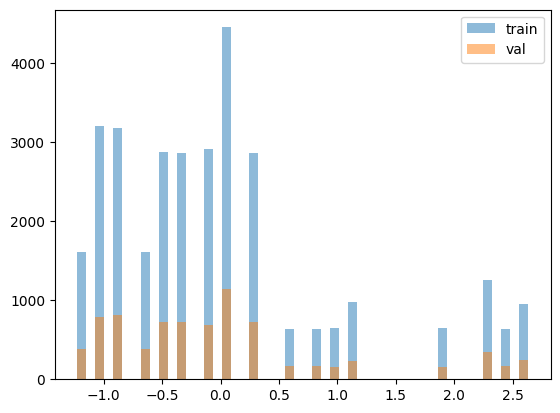

In [7]:
plt.hist(X_train_norm[:,1].numpy(), bins=50, alpha=0.5, label='train')
plt.hist(X_val_norm[:,1].numpy(), bins=50, alpha=0.5, label='val')
plt.legend()
plt.show()

### <div style= 'color: yellow'> NN Definition

In [40]:
import torch
import torch.nn as nn

# Define Neural Network
class PP_NN(nn.Module):
    def __init__(self, input_dim=6, hidden_dim=128, output_dim=1):
        super(PP_NN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, hidden_dim//2)
        self.fc5 = nn.Linear(hidden_dim//2, output_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.01) # Dropout layer for regularization
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        return self.fc5(x)

PP_NN()

PP_NN(
  (fc1): Linear(in_features=6, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=64, bias=True)
  (fc5): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.01, inplace=False)
)

### <div style= 'color: yellow'> Train the model (batch wise gradient descent) and plot losses

Epoch [100/3000] | Train Loss: 0.060166 | Val Loss: 0.071348
Epoch [200/3000] | Train Loss: 0.054272 | Val Loss: 0.054130
Epoch [200/3000] | Train Loss: 0.054272 | Val Loss: 0.054130
Epoch [300/3000] | Train Loss: 0.051180 | Val Loss: 0.052605
Epoch [300/3000] | Train Loss: 0.051180 | Val Loss: 0.052605
Epoch [400/3000] | Train Loss: 0.053658 | Val Loss: 0.061037
Epoch [400/3000] | Train Loss: 0.053658 | Val Loss: 0.061037
Epoch [500/3000] | Train Loss: 0.048875 | Val Loss: 0.053699
Epoch [500/3000] | Train Loss: 0.048875 | Val Loss: 0.053699
Epoch [600/3000] | Train Loss: 0.047795 | Val Loss: 0.052932
Epoch [600/3000] | Train Loss: 0.047795 | Val Loss: 0.052932
Epoch [700/3000] | Train Loss: 0.047674 | Val Loss: 0.053304
Epoch [700/3000] | Train Loss: 0.047674 | Val Loss: 0.053304
Epoch [800/3000] | Train Loss: 0.047155 | Val Loss: 0.053539
Epoch [800/3000] | Train Loss: 0.047155 | Val Loss: 0.053539
Epoch [900/3000] | Train Loss: 0.044554 | Val Loss: 0.053928
Epoch [900/3000] | Train

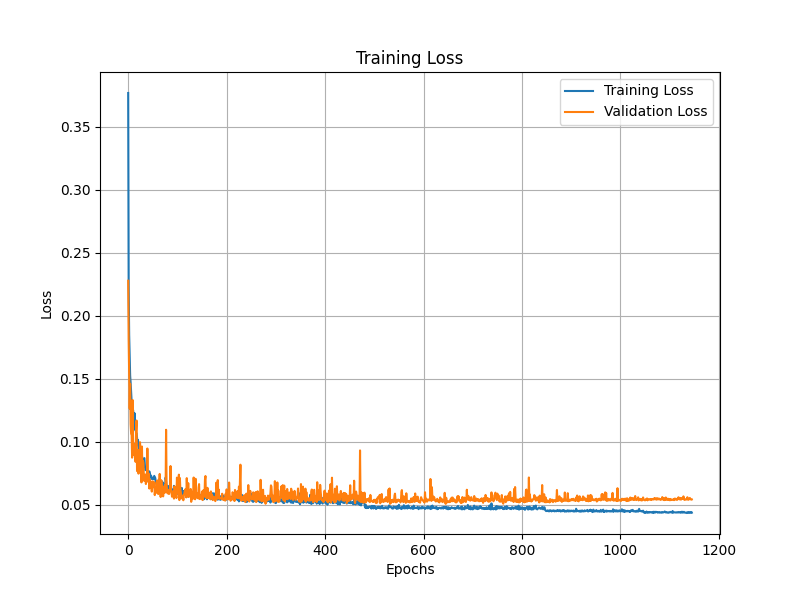

In [41]:
# Initialize the model
model = PP_NN().to(device)

# Loss and Optimizer
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=200)

# Mini-batch setup
batch_size = 128
train_dataset = torch.utils.data.TensorDataset(X_train_norm, y_train_norm)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = torch.utils.data.TensorDataset(X_val_norm, y_val_norm)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

# Training loop
epochs = 3000  # fewer epochs because mini-batch converges faster
training_losses = []
val_losses = []

best_val_loss = float('inf')
patience = 500  # Number of epochs to wait for improvement before stopping
patience_counter = 0

for epoch in range(epochs):
    # Training
    model.train()
    train_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * X_batch.size(0)

    train_loss /= len(train_loader.dataset)
    training_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            val_outputs = model(X_batch)
            loss = criterion(val_outputs, y_batch)
            val_loss += loss.item() * X_batch.size(0)
    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)

    # Step the scheduler
    scheduler.step(val_loss)

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Save the best model weights
        best_model_state = model.state_dict()
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{epochs}] | "
              f"Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}")

# Restore best model
model.load_state_dict(best_model_state)
print(f"Training finished. Best validation loss: {best_val_loss:.4f}")

# Plot Training Loss
plt.figure(figsize=(8, 6))
plt.plot(training_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.grid()
plt.legend()
plt.show()

# Save trained model
torch.save(model.state_dict(), "PP_TOV_Emulator_Real_model1.pth")

### <div style= 'color: yellow'> Load the trained model for evaluation

In [32]:
# # Instantiate the model class
# model = PP_NN()

# # Load the saved state dict
# model.load_state_dict(torch.load(f"/home/kay/ML-for-Neutron-Stars/3_PP_emulator_real_data/PP_TOV_Emulator_Real_model2.pth"))

model.eval()  # Set the model to evaluation mode
model.to(device)

PP_NN(
  (fc1): Linear(in_features=6, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=16, bias=True)
  (fc4): Linear(in_features=16, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.01, inplace=False)
)

### <div style= 'color: yellow'> Evaluate / compare TOV vs NN predictions for a random subsample of EOS parameters

m: 0.6, L: 80.0, n_v, 160.0, n_d: 1.73, B: 0.15
[inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf
 inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf
 inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf
 inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf
 inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf
 inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf
 inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf
 inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf
 inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf
 inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf
 inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf
 inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf
 inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf
 in

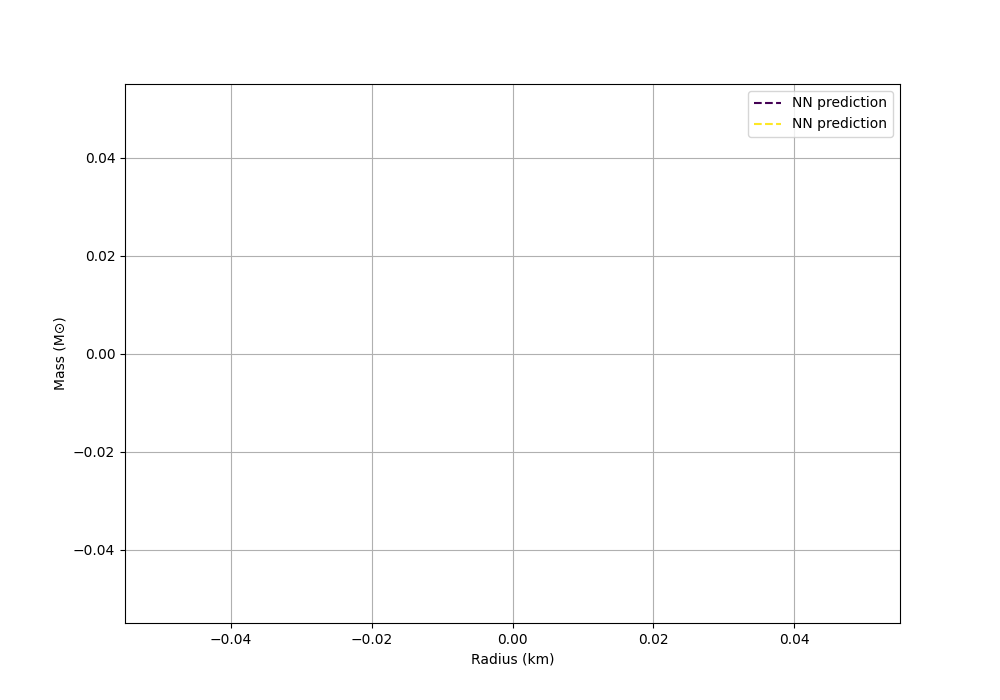

In [36]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import os
import re
%matplotlib widget


# Helper: extract EOS params ###################################################
def extract_eos_params(filename):
    # Example filename: MREoSm55L50J32T0_n150_Yp+RGgen_v0.00d0.90Bn000.dat
    pattern_m = r"m(?P<m>\d+)"
    pattern_L = r"L(?P<L>\d+)"
    pattern_n = r"n(?P<n>\d+)"
    pattern_d = r"d(?P<d>\d+\.\d+)"  # Corrected for d0.90 format
    pattern_B = r"B[np](?P<B>\d+)"  # Simplified: no need to capture the type if not used

    # Match the filename to the patterns
    match_m = re.search(pattern_m, filename)
    match_L = re.search(pattern_L, filename)
    match_n = re.search(pattern_n, filename)
    match_d = re.search(pattern_d, filename)
    match_B = re.search(pattern_B, filename)
    
    # Check if all matches were found to prevent AttributeError
    if not all([match_m, match_L, match_n, match_d, match_B]):
        print(f"Error matching patterns in filename: {filename}")
        # Consider raising a more helpful error or skipping the file
        return None, None, None, None, None

    m = float(match_m.group('m')) / 100                 # mass
    L = float(match_L.group('L'))                       # slope parameter
    n = float(match_n.group('n'))                       # vector coupling
    d = float(match_d.group('d'))                       # dipole coupling
    # Use group('B') to get the digits, not group(1) 
    B = float(match_B.group('B')) / 1000                # back constant
    
    return m, L, n, d, B


# Pick 10 random EOS files (each file = one M–R curve) #########################
# Load the list of files that were actually used for training
training_file_pool = np.load(f"Datasets/{NUM_FILES_TO_USE}files_used_for_training.npy", allow_pickle=True)
selected_files = np.random.choice(training_file_pool, size=2, replace=False) # size is the number of EOS curves

# PLotting #####################################################################
plt.figure(figsize=(10, 7))
colors = plt.cm.viridis(np.linspace(0, 1, len(selected_files)))

for color, file in zip(colors, selected_files):
    # Extract EOS params
    fname = os.path.basename(file)
    m, L, n_v, d, B = extract_eos_params(fname)

    print(f"m: {m}, L: {L}, n_v, {n_v}, n_d: {d}, B: {B}")

    # Load M-R
    data = np.loadtxt(file)
    mass_vals = data[:, 1].astype(np.float32)
    radius_vals = data[:, 2].astype(np.float32)

    # Store original
    original_radius = radius_vals.copy()

    # Build input features
    inputs = np.column_stack([
        np.full_like(mass_vals, m),
        np.full_like(mass_vals, L),
        np.full_like(mass_vals, n_v),
        np.full_like(mass_vals, d),
        np.full_like(mass_vals, B),
        mass_vals
    ]).astype(np.float32)

    # Apply same ad-hoc scaling
    inputs_scaled = inputs.copy()
    inputs_scaled[:, 1] /= 100.0
    inputs_scaled[:, 4] /= 0.2

    X_mean = X_mean.to(device)
    X_std = X_std.to(device)
    y_mean = y_mean.to(device)
    y_std = y_std.to(device)
    inp = torch.tensor(inputs_scaled, dtype=torch.float32).cpu().to(device)
    inp_norm = (inp - X_mean) / X_std

    # Prediction ###############################################################
    with torch.no_grad():
        pred_norm = model(inp_norm)
        logR_pred = pred_norm * y_std.to(pred_norm.device) + y_mean.to(pred_norm.device)
        R_pred = (torch.exp(logR_pred) - 1e-6).cpu().numpy().flatten()

    print(R_pred)
    # Plot
    # plt.plot(radius_vals, mass_vals, "-", color=color, label=f"EOS original")
    plt.plot(R_pred, mass_vals, "--", color=color, label=f"NN prediction")
    
plt.xlabel("Radius (km)")
plt.ylabel("Mass (M⊙)")
plt.grid()
plt.legend()
plt.show()


In [14]:
print("y_mean:", y_mean)
print("y_std:", y_std)
print("pred_norm min/max:", pred_norm.min().item(), pred_norm.max().item())


y_mean: tensor([[2.6267]], device='cuda:0')
y_std: tensor([[0.2155]], device='cuda:0')
pred_norm min/max: 105.52985382080078 117.06230926513672
tensor([[2.6267]], device='cuda:0')
y_std: tensor([[0.2155]], device='cuda:0')
pred_norm min/max: 105.52985382080078 117.06230926513672


### <div style= 'color: orange'> Model Metrics

In [17]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Concatenate stored curves into 1D arrays
orig_radius_all = np.concatenate(original_radius)
pred_radius_all = np.concatenate(predicted_radius)

# Compute metrics
mae_radius = mean_absolute_error(orig_radius_all, pred_radius_all)
rmse_radius = np.sqrt(mean_squared_error(orig_radius_all, pred_radius_all))
r2_radius = r2_score(orig_radius_all, pred_radius_all)

# Normalized RMSE
norm_rmse = rmse_radius / np.mean(orig_radius_all)

print(f"Radius: MAE={mae_radius:.4f}, RMSE={rmse_radius:.4f}, R²={r2_radius:.4f}")
print(f"Normalized RMSE = {norm_rmse:.4f}")


ValueError: zero-dimensional arrays cannot be concatenated